count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


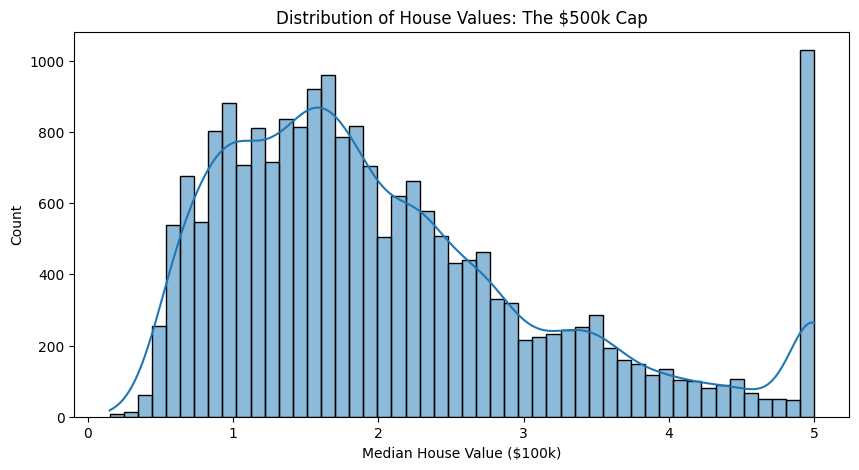

In [2]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Ingest Data
data = fetch_california_housing(as_frame=True)
df = data.frame

# 2. Inspect the "Ceiling Effect"
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()


In [9]:
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the "Tukey Fence"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


Exercise 2: Visualizing the IQR

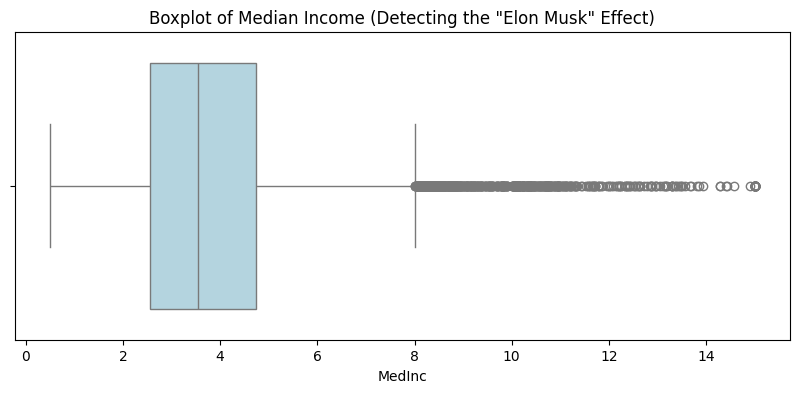

In [5]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()

#Phase 3: Algorithmic Anomaly Detection

Exercise 3: Implementing the Isolation Forest

In [6]:
# Initialize the model
# contamination=0.05: We estimate ~5% of the data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Features to analyze (Income, House Age, Average Rooms)
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[features])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


Exercise 4: Human vs Machine (Visual Comparison)

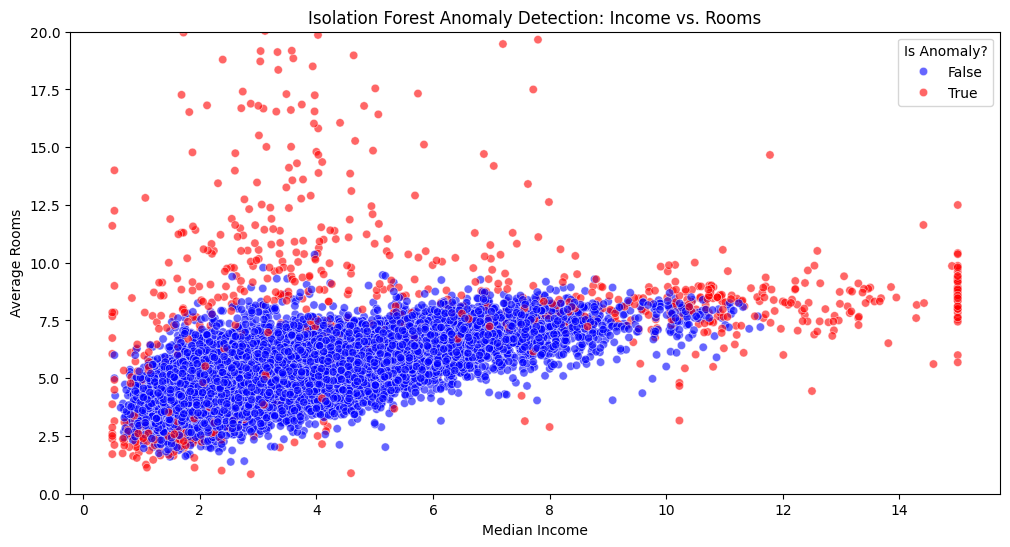

In [7]:
plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df, 
    x='MedInc', 
    y='AveRooms', 
    hue='outlier_iso', 
    palette={True: 'red', False: 'blue'}, 
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()

#Phase 4: Robustness Report

Normal points: 19608
Outlier points: 1032
Total: 20640

COMPARATIVE STATISTICS TABLE
  Group    Variable     Mean  Median  Std Dev     MAD
 Normal      MedInc 3.769613 3.51560 1.640561 1.03165
 Normal MedHouseVal 2.037000 1.78900 1.114117 0.67400
Outlier      MedInc 5.790782 4.25695 4.145354 2.49190
Outlier MedHouseVal 2.668172 2.05700 1.634770 1.10300

INEQUALITY WEDGE ANALYSIS (Outliers Only)
   Variable     Mean  Median  Inequality Wedge (Mean - Median)
     MedInc 5.790782 4.25695                          1.533832
MedHouseVal 2.668172 2.05700                          0.611172

Interpretation: Positive wedge indicates RIGHT SKEW (outliers pull mean upward)



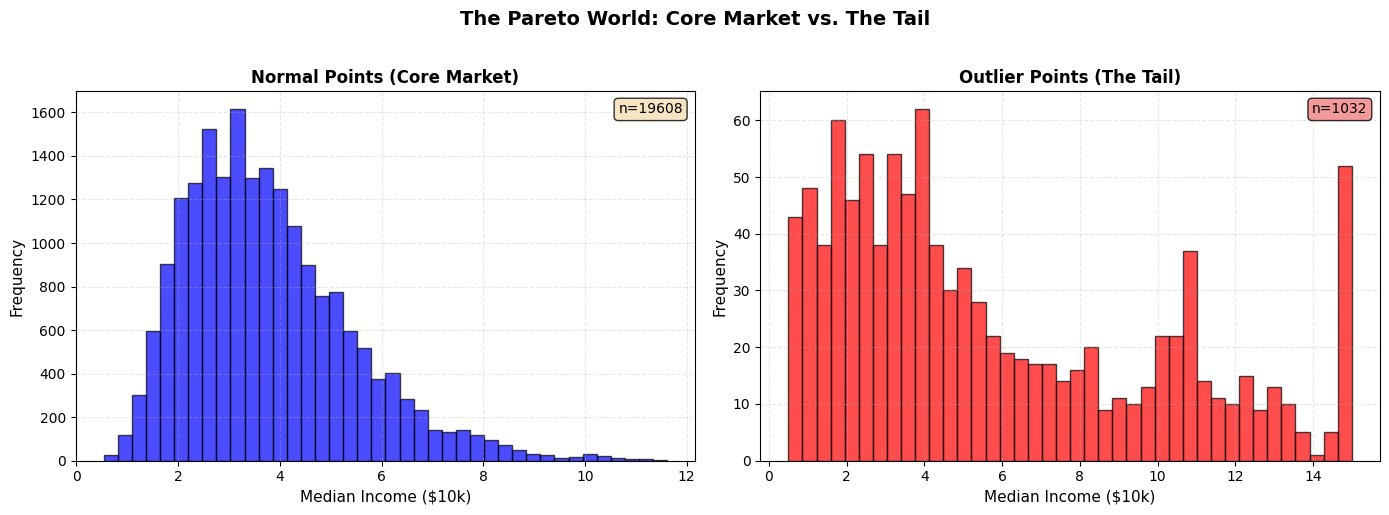

In [8]:
import numpy as np
from scipy import stats

# ============================================================
# COMPARATIVE FORENSICS REPORT
# ============================================================

# 1. Split data into normal and outlier DataFrames
df_normal = df[df['outlier_iso'] == False].copy()
df_outlier = df[df['outlier_iso'] == True].copy()

print(f"Normal points: {len(df_normal)}")
print(f"Outlier points: {len(df_outlier)}")
print(f"Total: {len(df)}\n")

# 2. Calculate Mean, Median, Std Dev, and MAD for both groups
# Helper function to calculate MAD (Median Absolute Deviation)
def calculate_mad(data):
    """Calculate Median Absolute Deviation"""
    return np.median(np.abs(data - np.median(data)))

# Create summary statistics
stats_summary = pd.DataFrame({
    'Group': ['Normal', 'Normal', 'Outlier', 'Outlier'],
    'Variable': ['MedInc', 'MedHouseVal', 'MedInc', 'MedHouseVal'],
    'Mean': [
        df_normal['MedInc'].mean(),
        df_normal['MedHouseVal'].mean(),
        df_outlier['MedInc'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'Median': [
        df_normal['MedInc'].median(),
        df_normal['MedHouseVal'].median(),
        df_outlier['MedInc'].median(),
        df_outlier['MedHouseVal'].median()
    ],
    'Std Dev': [
        df_normal['MedInc'].std(),
        df_normal['MedHouseVal'].std(),
        df_outlier['MedInc'].std(),
        df_outlier['MedHouseVal'].std()
    ],
    'MAD': [
        calculate_mad(df_normal['MedInc'].values),
        calculate_mad(df_normal['MedHouseVal'].values),
        calculate_mad(df_outlier['MedInc'].values),
        calculate_mad(df_outlier['MedHouseVal'].values)
    ]
})

print("="*80)
print("COMPARATIVE STATISTICS TABLE")
print("="*80)
print(stats_summary.to_string(index=False))
print()

# 3. Calculate Inequality Wedge (Mean - Median) for outliers only
print("="*80)
print("INEQUALITY WEDGE ANALYSIS (Outliers Only)")
print("="*80)

inequality_wedge = pd.DataFrame({
    'Variable': ['MedInc', 'MedHouseVal'],
    'Mean': [
        df_outlier['MedInc'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'Median': [
        df_outlier['MedInc'].median(),
        df_outlier['MedHouseVal'].median()
    ],
    'Inequality Wedge (Mean - Median)': [
        df_outlier['MedInc'].mean() - df_outlier['MedInc'].median(),
        df_outlier['MedHouseVal'].mean() - df_outlier['MedHouseVal'].median()
    ]
})

print(inequality_wedge.to_string(index=False))
print()
print("Interpretation: Positive wedge indicates RIGHT SKEW (outliers pull mean upward)")
print("="*80)
print()

# 4. Create visualization: Comparative histograms of MedInc
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of MedInc for Normal points (Blue)
axes[0].hist(df_normal['MedInc'], bins=40, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Normal Points (Core Market)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Median Income ($10k)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].text(0.98, 0.97, f'n={len(df_normal)}', 
             transform=axes[0].transAxes, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Right: Histogram of MedInc for Outliers (Red)
axes[1].hist(df_outlier['MedInc'], bins=40, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title('Outlier Points (The Tail)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Median Income ($10k)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].text(0.98, 0.97, f'n={len(df_outlier)}', 
             transform=axes[1].transAxes, 
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

fig.suptitle('The Pareto World: Core Market vs. The Tail', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()